In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

device = "cuda"

Using cuda device
GPU: NVIDIA GeForce RTX 3060


# Data loading

In [2]:
training_data_path = Path("data/CMI/train.csv")
training_data_demo_path = Path("data/CMI/train_demographics.csv")

test_data_path = Path("data/CMI/test.csv")
test_data_demo_path = Path("data/CMI/test_demographics.csv")


train_df = pd.read_csv(training_data_path)
train_demo_df = pd.read_csv(training_data_demo_path)
test_df = pd.read_csv(test_data_path)
test_demo_df = pd.read_csv(test_data_demo_path)


# Data visualization

In [3]:
train_df.head(60)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,SEQ_000007_000005,Target,SEQ_000007,5,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.996094,...,-1.0,-1.0,118.0,114.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,SEQ_000007_000006,Target,SEQ_000007,6,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.035156,...,-1.0,-1.0,104.0,118.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,SEQ_000007_000007,Target,SEQ_000007,7,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.730469,...,-1.0,-1.0,105.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,SEQ_000007_000008,Target,SEQ_000007,8,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.535156,...,-1.0,-1.0,103.0,122.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,SEQ_000007_000009,Target,SEQ_000007,9,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.921875,...,-1.0,-1.0,104.0,123.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Dataset

In [ ]:
class CMIIMUDataset(Dataset):
    def __init__(self, df, transform=None, device='cpu'):
        self.device = device
        self.df = df
        self.transform = transform
        self.features = []  # Initialize features list
        self.scaler = StandardScaler()

        excluded_cols = {
            'gesture', 'sequence_type', 'behavior', 'orientation',  # train-only
            'row_id', 'subject', 'phase',  # metadata
            'sequence_id', 'sequence_counter'  # identifiers
        }
        
        thermal_tof_cols = [col for col in df.columns if col.startswith('thm_') or col.startswith('tof_')]
        excluded_cols.update(thermal_tof_cols)

        # Get feature columns (all columns except excluded ones)
        feature_cols = [col for col in df.columns if col not in excluded_cols]

        # Build sequences
        for seq_id, group in df.groupby('sequence_id'):
            data = group[feature_cols].copy()

            # fill missing values forward and backward
            data = pd.DataFrame(data).ffill().bfill().fillna(0).values

            # Standardize features
            data = self.scaler.fit_transform(data)
            self.features.append(data)  # Convert to numpy array

        self.labels = df.groupby('sequence_id')['gesture'].first().values

        # Pad sequences to the same length
        self.features = nn.utils.rnn.pad_sequence([torch.tensor(f, dtype=torch.float32, device=self.device) for f in self.features], batch_first=True)

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        self.labels = torch.tensor(self.labels, dtype=torch.long, device=self.device)

    def print(self):
        print(self.features.shape)
        print(self.labels.shape)
        print(self.features[:3])
        print(self.labels[:3])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature, label

In [52]:
dataset = CMIIMUDataset(train_df, device=device)
dataset.print()

# Print unique gestures and their encoded values
print("\nUnique gestures and their encoded values:")
for gesture, encoded in zip(np.unique(train_df['gesture']), torch.unique(dataset.labels)):
    print(f"Gesture: {gesture} -> Encoded: {encoded}")

print("\nNumber of unique gestures:", len(np.unique(train_df['gesture'])))

torch.Size([8151, 700, 7])
torch.Size([8151])
tensor([[[ 0.4012,  0.7610, -0.9592,  ..., -1.3253, -0.6677,  0.6997],
         [ 0.6020,  0.7610, -1.0586,  ..., -1.0598, -0.5601,  0.3337],
         [-0.3255,  0.4947, -0.0673,  ...,  0.1174, -0.1468, -0.6854],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5883, -1.7059,  1.2497,  ..., -0.3209,  1.6464, -1.4810],
         [-0.7295, -1.7059,  1.2656,  ..., -0.2586,  1.6461, -1.4767],
         [-0.6571, -1.6939,  1.2656,  ..., -0.2150,  1.6357, -1.4392],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.8468,  0.3204, -0.2918,  ...,  0.3583,  0.2276,  0.0715],

In [51]:
print("\nChecking for NaN values in features:")
print("NaN values in features:", torch.isnan(dataset.features).any())
print("Number of NaN values:", torch.isnan(dataset.features).sum())

print("\nChecking feature statistics:")
print("Min value:", torch.min(dataset.features))
print("Max value:", torch.max(dataset.features))
print("Mean value:", torch.mean(dataset.features))
print("Std value:", torch.std(dataset.features))


Checking for NaN values in features:
NaN values in features: tensor(False, device='cuda:0')
Number of NaN values: tensor(0, device='cuda:0')

Checking feature statistics:
Min value: tensor(-9.0249, device='cuda:0')
Max value: tensor(12.8981, device='cuda:0')
Mean value: tensor(-3.0563e-12, device='cuda:0')
Std value: tensor(0.3169, device='cuda:0')


In [53]:
print(dataset.features.shape)
print(dataset.labels.shape)

torch.Size([8151, 700, 7])
torch.Size([8151])


In [54]:
type(dataset.features), type(dataset.labels)

(torch.Tensor, torch.Tensor)

# Model

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [146]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, hidden_size // 4)
        self.relu4 = nn.ReLU()
        self.fcout = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fcout(out)
        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Batch normalization dla danych wejściowych
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # LSTM z dropout
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        # Batch normalization po LSTM
        self.batch_norm_hidden = nn.BatchNorm1d(hidden_size)
        
        # Dropout przed warstwą liniową
        self.dropout = nn.Dropout(dropout_rate)
        
        # Warstwa liniowa
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Normalizacja danych wejściowych
        x = self.batch_norm_input(x)
        
        # Przygotowanie danych dla LSTM (batch_size, seq_length=1, input_size)
        x = x.unsqueeze(1)
        
        # Inicjalizacja stanów ukrytych
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Bierzemy ostatni output
        out = out[:, -1, :]
        
        # Normalizacja po LSTM
        out = self.batch_norm_hidden(out)
        
        # Dropout
        out = self.dropout(out)
        
        # Warstwa liniowa
        out = self.fc(out)
        
        return out

# Training loops

In [36]:
train_data, val_data = random_split(dataset, [0.8, 0.2])
def get_dataloaders(train_data, val_data, batch_size=1024):
    train_dataloader = DataLoader(
            train_data, 
            batch_size=batch_size, 
            shuffle=True,  # Włącz shuffle dla danych treningowych
            num_workers=0,  # Użyj wielu workerów do ładowania danych
            pin_memory=True  # Przyspiesz transfer do GPU
        )
        
    val_dataloader = DataLoader(
            val_data, 
            batch_size=batch_size, 
            shuffle=False,  # Nie shuffle'uj danych walidacyjnych
            num_workers=0,
            pin_memory=True
        )
    return train_dataloader, val_dataloader

In [131]:
def train_one_epoch(X, model, loss_fn, optimizer, epoch_idx, writer):
    running_loss = 0.0
    last_loss = 0.0
    quarter = max(1, len(X) // 4) # log every 1/4 of an epoch
    n_in_window = 0

    for i, data in enumerate(X):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        logits = outputs.permute(0, 2, 1).mean(dim=2)  # Adjust dimensions for CrossEntropyLoss
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        n_in_window += 1

        if ((i + 1) % quarter == 0) or ((i + 1) == len(X)):
            last_loss = running_loss / n_in_window  # średnia w oknie
            pct = int(round(100 * (i + 1) / len(X)))
            print(f"  epoch {epoch_idx+1} {pct}% ({i+1}/{len(X)}) - loss: {last_loss:.6f}")

            # globalny krok: łączny numer batcha od początku treningu epoki
            tb_x = epoch_idx * len(X) + (i + 1)
            writer.add_scalar("Loss/train", last_loss, tb_x)

            # reset okna
            running_loss = 0.
            n_in_window = 0

    return last_loss


In [141]:
def train_loop(X: DataLoader, y: DataLoader, model, loss_fn, optimizer, name: str, epochs=10, batch_size=32):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    writer = SummaryWriter('runs/{}_{}'.format(name, timestamp))
    epoch_number = 0

    best_vloss = 1_000_000.

    train_dataloader, validation_loader = get_dataloaders(X, y, batch_size=batch_size)

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, epoch_number, writer)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        correct = 0
        total = 0
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vlogits = voutputs.permute(0, 2, 1).mean(dim=2)  # Adjust dimensions for CrossEntropyLoss
                vloss = loss_fn(vlogits, vlabels)
                running_vloss += vloss

                _, predicted = torch.max(vlogits, 1)
                total += vlabels.size(0)
                correct += (predicted == vlabels).sum().item()


        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch_number + 1)
        writer.add_scalar('Validation Loss', avg_vloss, epoch_number + 1)
        writer.add_scalar('Training Loss', avg_loss, epoch_number + 1)
        writer.add_scalar('Accuracy', accuracy, epoch_number + 1) 
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}.pt'.format(timestamp)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

# Train

In [148]:
model = ComplexNN(input_size=dataset.features.shape[2], hidden_size=256, num_classes=len(torch.unique(dataset.labels)))
model.to(device)
print(model)

ComplexNN(
  (fc1): Linear(in_features=7, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (relu4): ReLU()
  (fcout): Linear(in_features=64, out_features=18, bias=True)
)


In [149]:
loss_fn = nn.CrossEntropyLoss().to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=2
)

# Inicjalizacja wag
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)


ComplexNN(
  (fc1): Linear(in_features=7, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (relu4): ReLU()
  (fcout): Linear(in_features=64, out_features=18, bias=True)
)

In [150]:
# Uruchomienie
results = train_loop(
    model=model,
    X=train_data,
    y=val_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=500,
    batch_size=256,  # Zwiększony batch size dla lepszej stabilności
    name='CMI_Linear_v2'
)

EPOCH 1:


/tmp/ipykernel_1237/791210588.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


  epoch 1 23% (6/26) - loss: 2.817968
  epoch 1 46% (12/26) - loss: 2.757698
  epoch 1 69% (18/26) - loss: 2.696116
  epoch 1 92% (24/26) - loss: 2.668855
  epoch 1 100% (26/26) - loss: 2.622650
Accuracy: 10.00%
LOSS train 2.6226497888565063 valid 2.6567394733428955
EPOCH 2:
  epoch 2 23% (6/26) - loss: 2.640458
  epoch 2 46% (12/26) - loss: 2.595726
  epoch 2 69% (18/26) - loss: 2.535127
  epoch 2 92% (24/26) - loss: 2.527547
  epoch 2 100% (26/26) - loss: 2.473423
Accuracy: 13.50%
LOSS train 2.473422646522522 valid 2.505073070526123
EPOCH 3:
  epoch 3 23% (6/26) - loss: 2.499081
  epoch 3 46% (12/26) - loss: 2.441721
  epoch 3 69% (18/26) - loss: 2.456260
  epoch 3 92% (24/26) - loss: 2.404000
  epoch 3 100% (26/26) - loss: 2.347754
Accuracy: 19.14%
LOSS train 2.3477540016174316 valid 2.3746562004089355
EPOCH 4:
  epoch 4 23% (6/26) - loss: 2.349802
  epoch 4 46% (12/26) - loss: 2.361416
  epoch 4 69% (18/26) - loss: 2.355249
  epoch 4 92% (24/26) - loss: 2.335911
  epoch 4 100% (26/

# Uwagi

- KURWA W KONCU POPRAWNY DATASET ALE UWAGAAAAAAAA
- PODZIEL ZBIOR TRAIN/VAL
- OGARNIJ TE ZJEBANE PETLE TRENINGOWE BO WSTYD
- Prawdopodobnie StandardScaler wykonac na koncu budowania wszystkich sekwencji
- 
- Dopracuj model na lepsiejszy bo to ładnie już idzie
- Dodaj monitoring z TensorBoard
- Po dobrym modelu idz na rozszerzenie datasetu o TOF i reszte

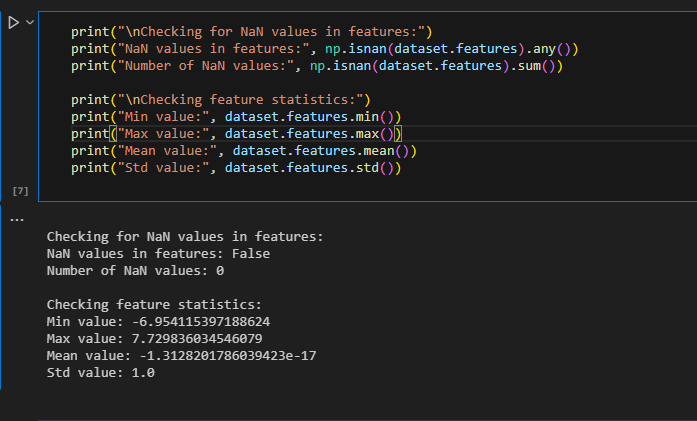

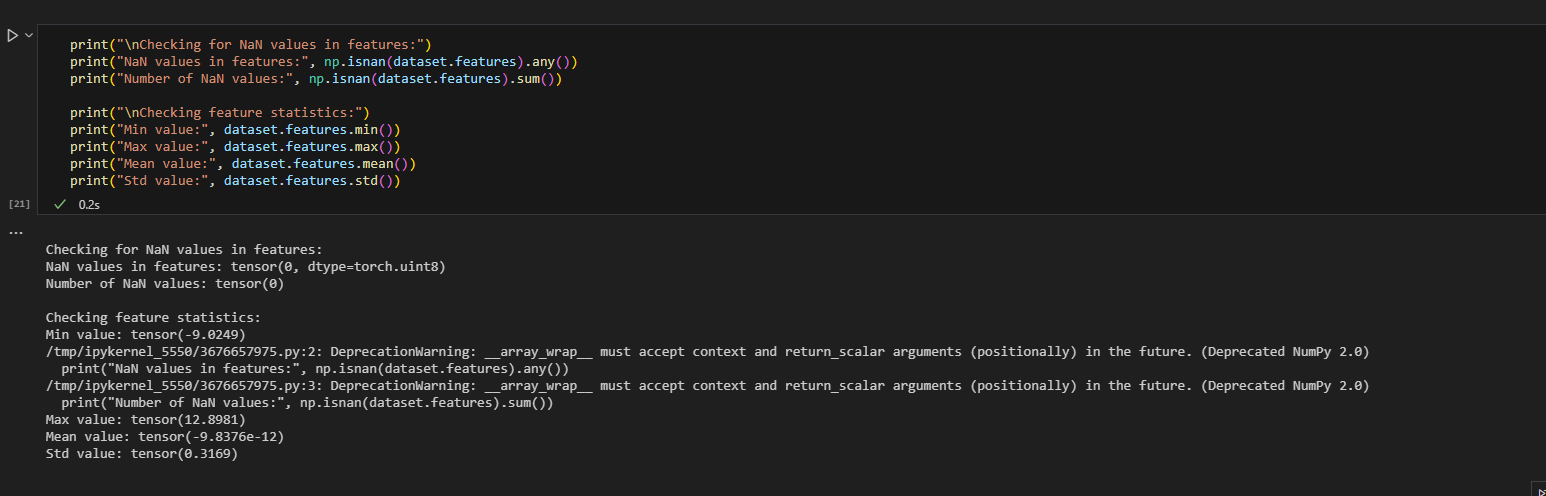

do zobaczenia tensorboard wpisz w terminal 
tensorboard --logdir runs